# Fine tuning BERT

Загружаем зависимости:

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from torch.optim.lr_scheduler import OneCycleLR

Загружаем исходный набор текстов и удаляем из него все лишнее.

In [2]:
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    authors = [
        'чехов', 'чехова', 'чехову', 'чеховым', 'чехове', 'антон', 'антона', 'антону', 'антоном', 'антоне', 'павлович', 'павловича', 'павловичу', 'павловичем', 'павловиче',
        'куприн', 'куприна', 'куприну', 'куприным', 'куприне', 'александр', 'александра', 'александру', 'александром', 'александре', 'иванович', 'ивановича', 'ивановичу', 'ивановичем', 'ивановиче',
        'бунин', 'бунина', 'бунину', 'буниным', 'бунине', 'иван', 'ивана', 'ивану', 'иваном', 'иване', 'алексеевич', 'алексеевича', 'алексеевичу', 'алексеевичем', 'алексеевиче',
        'карамзин', 'карамзина', 'карамзину', 'карамзиным', 'карамзине', 'николай', 'николая', 'николаю', 'николаем', 'николае', 'михайлович', 'михайловича', 'михайловичу', 'михайловичем', 'михайловиче',
        'достоевский', 'достоевского', 'достоевскому', 'достоевским', 'достоевском', 'федор', 'федора', 'федору', 'федором', 'федоре', 'федька', 'феденька', 'михайлович', 'михайловича', 'михайловичу', 'михайловичем', 'михайловиче',
        'лермонтов', 'лермонтова', 'лермонтову', 'лермонтовым', 'лермонтове', 'михаил', 'михаила', 'михаилу', 'михаилом', 'михаиле', 'миша', 'мишель', 'юрьевич', 'юрьевича', 'юрьевичу', 'юрьевичем', 'юрьевиче',
        'пушкин', 'пушкина', 'пушкину', 'пушкиным', 'пушкине', 'александр', 'александра', 'александру', 'александром', 'александре', 'саша', 'сергеевич', 'сергеевича', 'сергеевичу', 'сергеевичем', 'сергеевиче',
        'мамин', 'мамина', 'мамину', 'маминым', 'мамине', 'сибиряк', 'сибиряка', 'сибиряку', 'сибиряком', 'сибиряке', 'мамин-сибиряк', 'мамина-сибиряка', 'мамину-сибиряку', 'маминым-сибиряком', 'мамине-сибиряке', 'дмитрий', 'дмитрия', 'дмитрию', 'дмитрием', 'дмитрии', 'наркисович', 'наркисовича', 'наркисовичу', 'наркисовичем', 'наркисовиче',
        'гоголь', 'гоголя', 'гоголю', 'гоголем', 'гоголе', 'николай', 'николая', 'николаю', 'николаем', 'николае', 'васильевич', 'васильевича', 'васильевичу', 'васильевичем', 'васильевиче',
        'тургенев', 'тургенева', 'тургеневу', 'тургеневым', 'тургеневе', 'иван', 'ивана', 'ивану', 'иваном', 'иване', 'сергеевич', 'сергеевича', 'сергеевичу', 'сергеевичем', 'сергеевиче',
        'салтыков', 'салтыкова', 'салтыкову', 'салтыковым', 'салтыкове', 'щедрин', 'щедрина', 'щедрину', 'щедрином', 'щедрине', 'салтыков-щедрин', 'салтыкова-щедрина', 'салтыкову-щедрину', 'салтыковым-щедрином', 'салтыкове-щедрине', 'михаил', 'михаила', 'михаилу', 'михаилом', 'михаиле', 'евграфович', 'евграфовича', 'евграфовичу', 'евграфовичем', 'евграфовиче',
        'блок', 'блока', 'блоку', 'блоком', 'блоке', 'александр', 'александра', 'александру', 'александром', 'александре', 'александрович', 'александровича', 'александровичу', 'александровичем', 'александровиче',
        'есенин', 'есенина', 'есенину', 'есениным', 'есенине', 'сергей', 'сергея', 'сергею', 'сергеем', 'сергее', 'александрович', 'александровича', 'александровичу', 'александровичем', 'александровиче',
        'а.п.', 'а. п.', 'с.а.', 'с. а.', 'ф.м.', 'ф. м.', 'н.в.', 'н. в.', 'и.с.', 'и. с.', 'м.е.', 'м. е.'
    ]

    for author in authors:
        text = text.replace(author, '')

    return text

def load_data(file_path):
    df = pd.read_csv(file_path)

    df = df.drop(index=1918) # как и в прошлых экспериментах
    df = df.reset_index(drop=True)

    df['text'] = df['text'].apply(preprocess_text)

    print(f"Загружено {len(df)} записей\n")
    print(f"Уникальные авторы:\n {df['author'].unique()}\n")

    return df


file_path = 'https://storage.yandexcloud.net/auth-def-2024/datasets/meta_table_with_texts.csv'

df = load_data(file_path)

print(f"Размер датасета: {df.shape}\n")

Загружено 2564 записей

Уникальные авторы:
 ['Пушкин Александр Сергеевич' 'Карамзин Николай Михайлович'
 'Гоголь Николай Васильевич' 'Мамин-Сибиряк Дмитрий Наркисович'
 'Салтыков-Щедрин Михаил Евграфович' 'Куприн Александр Иванович'
 'Бунин Иван Алексеевич' 'Блок Александр Александрович'
 'Достоевский Федор Михайлович' 'Лермонтов Михаил Юрьевич'
 'Чехов Антон Павлович' 'Тургенев Иван Сергеевич'
 'Есенин Сергей Александрович']

Размер датасета: (2564, 7)



In [3]:
print(df['author'].value_counts())

author
Куприн Александр Иванович            390
Тургенев Иван Сергеевич              302
Карамзин Николай Михайлович          287
Мамин-Сибиряк Дмитрий Наркисович     256
Бунин Иван Алексеевич                233
Достоевский Федор Михайлович         200
Гоголь Николай Васильевич            188
Салтыков-Щедрин Михаил Евграфович    181
Чехов Антон Павлович                 173
Пушкин Александр Сергеевич           131
Блок Александр Александрович         118
Есенин Сергей Александрович           68
Лермонтов Михаил Юрьевич              37
Name: count, dtype: int64


In [4]:
authors = df['author'].unique()
author_to_id = {author: idx for idx, author in enumerate(authors)}
id_to_author = {idx: author for idx, author in enumerate(authors)}
df['author_id'] = df['author'].map(author_to_id)

print(f"Всего авторов: {len(authors)}")
print(author_to_id)

Всего авторов: 13
{'Пушкин Александр Сергеевич': 0, 'Карамзин Николай Михайлович': 1, 'Гоголь Николай Васильевич': 2, 'Мамин-Сибиряк Дмитрий Наркисович': 3, 'Салтыков-Щедрин Михаил Евграфович': 4, 'Куприн Александр Иванович': 5, 'Бунин Иван Алексеевич': 6, 'Блок Александр Александрович': 7, 'Достоевский Федор Михайлович': 8, 'Лермонтов Михаил Юрьевич': 9, 'Чехов Антон Павлович': 10, 'Тургенев Иван Сергеевич': 11, 'Есенин Сергей Александрович': 12}


Готовим три выборки:
*   Тренировочная
*   Для валидации
*   Тестовая

In [5]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['author_id'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['author_id'])

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер валидационной выборки: {val_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

Размер обучающей выборки: (1794, 8)
Размер валидационной выборки: (385, 8)
Размер тестовой выборки: (385, 8)


Классы для датасета и ранней остановки:

In [6]:
class AuthorshipDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0, path='best_bert_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f'Checkpoint сохранен: {-self.best_score:.6f}')

Датасеты:

In [7]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

train_dataset = AuthorshipDataset(
    train_df['text'].values,
    train_df['author_id'].values,
    tokenizer
)

test_dataset = AuthorshipDataset(
    test_df['text'].values,
    test_df['author_id'].values,
    tokenizer
)

val_dataset = AuthorshipDataset(
    val_df['text'].values,
    val_df['author_id'].values,
    tokenizer
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Батчи размера 16 требуют памяти, но дают более стабильное обучение.

10 эпох достаточно, но также будет использоваться механизм ранней остановки.

Используем CUDA (A100 GPU в Colab):

In [8]:
batch_size = 16
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

В качестве модели возьмем `DeepPavlov/rubert-base-cased`.

Параметры `hidden_dropout_prob` и `attention_probs_dropout_prob` были использованы для борьбы с переобучением, но эффекта не дали (если уже есть `weight_decay`), только замедлили `train()`.

In [10]:
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=len(authors),
    output_attentions=False,
    output_hidden_states=False,
    # hidden_dropout_prob=0.3,
    # attention_probs_dropout_prob=0.3
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

Оптимизатор с `weight_decay`. Без регуляризации разница между F1 на трейне и валидации превышала 10% уже на 2-3 эпохе.

In [11]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0.05)

`OneCycleLR` — это стратегия управления скоростью обучения (`lr`).

Как работает `OneCycleLR`:

* В начале обучения скорость обучения быстро растёт от маленького значения до большого.
* Затем скорость обучения медленно уменьшается почти до нуля к концу обучения.

Зачем:
Большой `lr` помогает быстрее начать обучение и избегать плохих локальных минимумов. Плавное уменьшение `lr` помогает точно прийти к хорошему минимуму. Далее будет приведен график изменения `lr`.

In [12]:
total_steps = len(train_dataloader) * num_epochs

scheduler = OneCycleLR(
    optimizer,
    max_lr=2e-5,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos',
    cycle_momentum=True,
    base_momentum=0.85,
    max_momentum=0.95,
    div_factor=25.0,
    final_div_factor=10000.0,
)

In [13]:
lr_history = []
momentum_history = []


def train():
    model.train()

    total_loss = 0
    total_f1 = 0

    for batch in tqdm(train_dataloader, desc="Обучение"):
        for param_group in optimizer.param_groups:
            lr_history.append(param_group['lr'])
            if 'momentum' in param_group:
                momentum_history.append(param_group['momentum'])

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        true_labels = labels.cpu().numpy()
        batch_f1 = f1_score(true_labels, preds, average='weighted')

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_f1 += batch_f1

    avg_loss = total_loss / len(train_dataloader)
    avg_f1 = total_f1 / len(train_dataloader)

    return avg_loss, avg_f1

def evaluate(model, dataloader):
    model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Оценка"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(true_labels)

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, avg_f1, all_preds, all_labels

## Обучение

In [14]:
model_file_name = 'best_bert_model.pt'

early_stopping = EarlyStopping(patience=3, path=model_file_name)

train_losses = []
train_f1_scores = []
val_losses = []
val_f1_scores = []
test_losses = []
test_f1_scores = []

for epoch in range(num_epochs):
    print(f"Эпоха {epoch + 1}/{num_epochs}")

    train_loss, train_f1 = train()
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)
    print(f"Обучение - Потеря: {train_loss:.4f}, F1: {train_f1:.4f}")

    val_loss, val_f1, val_preds, val_labels = evaluate(model, val_dataloader)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    print(f"Валидация - Потеря: {val_loss:.4f}, F1: {val_f1:.4f}")

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Раннее остановка! Модель перестала улучшаться.")
        break

model.load_state_dict(torch.load(model_file_name))

Эпоха 1/10


Обучение: 100%|██████████| 113/113 [06:15<00:00,  3.33s/it]


Обучение - Потеря: 2.3781, F1: 0.1588


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.75s/it]


Валидация - Потеря: 2.0718, F1: 0.2497
Checkpoint сохранен: 2.071815
Эпоха 2/10


Обучение: 100%|██████████| 113/113 [06:14<00:00,  3.32s/it]


Обучение - Потеря: 1.6486, F1: 0.4602


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.74s/it]


Валидация - Потеря: 1.1338, F1: 0.6487
Checkpoint сохранен: 1.133757
Эпоха 3/10


Обучение: 100%|██████████| 113/113 [06:14<00:00,  3.31s/it]


Обучение - Потеря: 0.8586, F1: 0.7823


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.73s/it]


Валидация - Потеря: 0.6680, F1: 0.8208
Checkpoint сохранен: 0.668046
Эпоха 4/10


Обучение: 100%|██████████| 113/113 [06:15<00:00,  3.32s/it]


Обучение - Потеря: 0.4653, F1: 0.8962


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.74s/it]


Валидация - Потеря: 0.5681, F1: 0.8446
Checkpoint сохранен: 0.568081
Эпоха 5/10


Обучение: 100%|██████████| 113/113 [06:15<00:00,  3.32s/it]


Обучение - Потеря: 0.2691, F1: 0.9379


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.74s/it]


Валидация - Потеря: 0.4408, F1: 0.8610
Checkpoint сохранен: 0.440791
Эпоха 6/10


Обучение: 100%|██████████| 113/113 [06:14<00:00,  3.31s/it]


Обучение - Потеря: 0.1600, F1: 0.9611


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.74s/it]


Валидация - Потеря: 0.5131, F1: 0.8716
EarlyStopping: 1/3
Эпоха 7/10


Обучение: 100%|██████████| 113/113 [06:15<00:00,  3.32s/it]


Обучение - Потеря: 0.0943, F1: 0.9786


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.74s/it]


Валидация - Потеря: 0.4854, F1: 0.8761
EarlyStopping: 2/3
Эпоха 8/10


Обучение: 100%|██████████| 113/113 [06:15<00:00,  3.32s/it]


Обучение - Потеря: 0.0551, F1: 0.9929


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.74s/it]


Валидация - Потеря: 0.4379, F1: 0.8907
Checkpoint сохранен: 0.437894
Эпоха 9/10


Обучение: 100%|██████████| 113/113 [06:15<00:00,  3.32s/it]


Обучение - Потеря: 0.0380, F1: 0.9966


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.75s/it]


Валидация - Потеря: 0.4462, F1: 0.8907
EarlyStopping: 1/3
Эпоха 10/10


Обучение: 100%|██████████| 113/113 [06:14<00:00,  3.32s/it]


Обучение - Потеря: 0.0330, F1: 0.9973


Оценка: 100%|██████████| 25/25 [01:33<00:00,  3.74s/it]


Валидация - Потеря: 0.4519, F1: 0.8905
EarlyStopping: 2/3


<All keys matched successfully>

## Несколько визуализаций

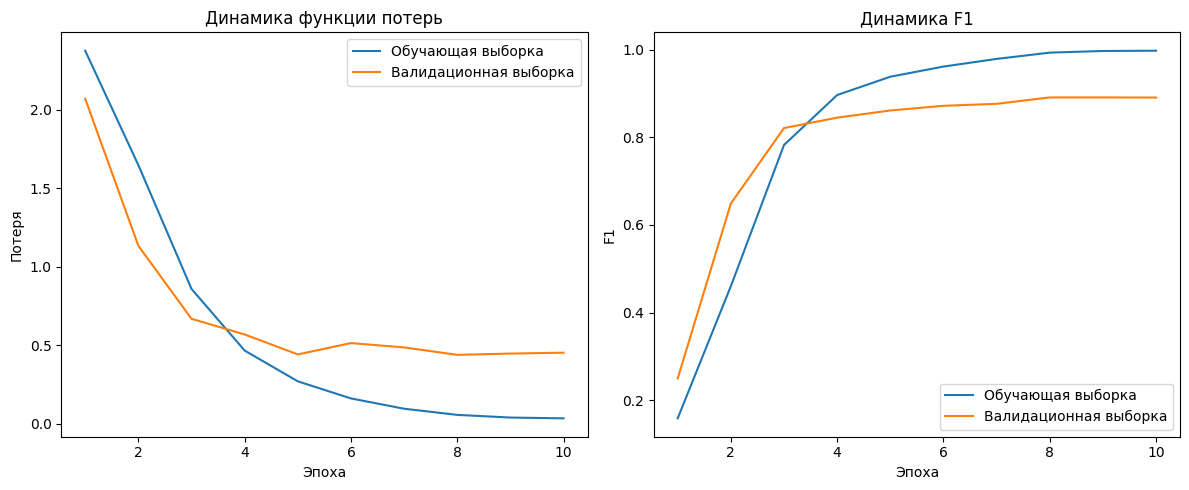

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Обучающая выборка')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Динамика функции потерь')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Обучающая выборка')
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('F1')
plt.title('Динамика F1')
plt.legend()

plt.tight_layout()
plt.show()

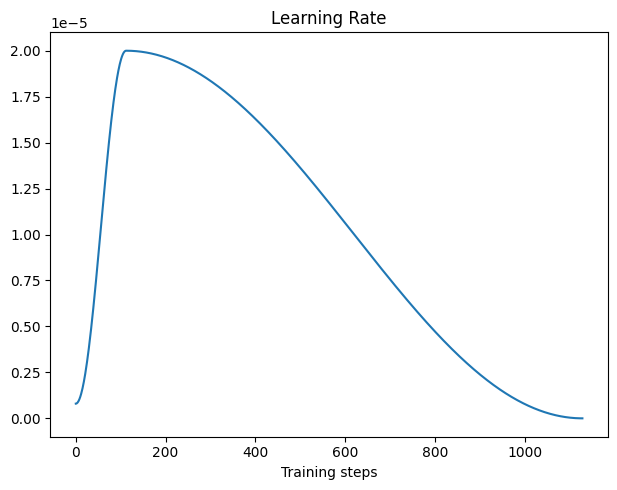

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lr_history)
plt.title('Learning Rate')
plt.xlabel('Training steps')

if momentum_history:
    plt.subplot(1, 2, 2)
    plt.plot(momentum_history)
    plt.title('Momentum')
    plt.xlabel('Training steps')

plt.tight_layout()
plt.show()

Оценка: 100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


Final F1: 0.9038275362527249
                                   precision    recall  f1-score   support

       Пушкин Александр Сергеевич       0.68      0.79      0.73        19
      Карамзин Николай Михайлович       0.97      0.91      0.94        43
        Гоголь Николай Васильевич       0.74      0.82      0.78        28
 Мамин-Сибиряк Дмитрий Наркисович       0.97      1.00      0.99        39
Салтыков-Щедрин Михаил Евграфович       0.96      0.93      0.94        27
        Куприн Александр Иванович       0.96      0.90      0.93        59
            Бунин Иван Алексеевич       0.87      0.94      0.90        35
     Блок Александр Александрович       0.83      0.83      0.83        18
     Достоевский Федор Михайлович       0.85      0.93      0.89        30
         Лермонтов Михаил Юрьевич       0.67      0.33      0.44         6
             Чехов Антон Павлович       1.00      0.96      0.98        26
          Тургенев Иван Сергеевич       0.98      0.93      0.95      

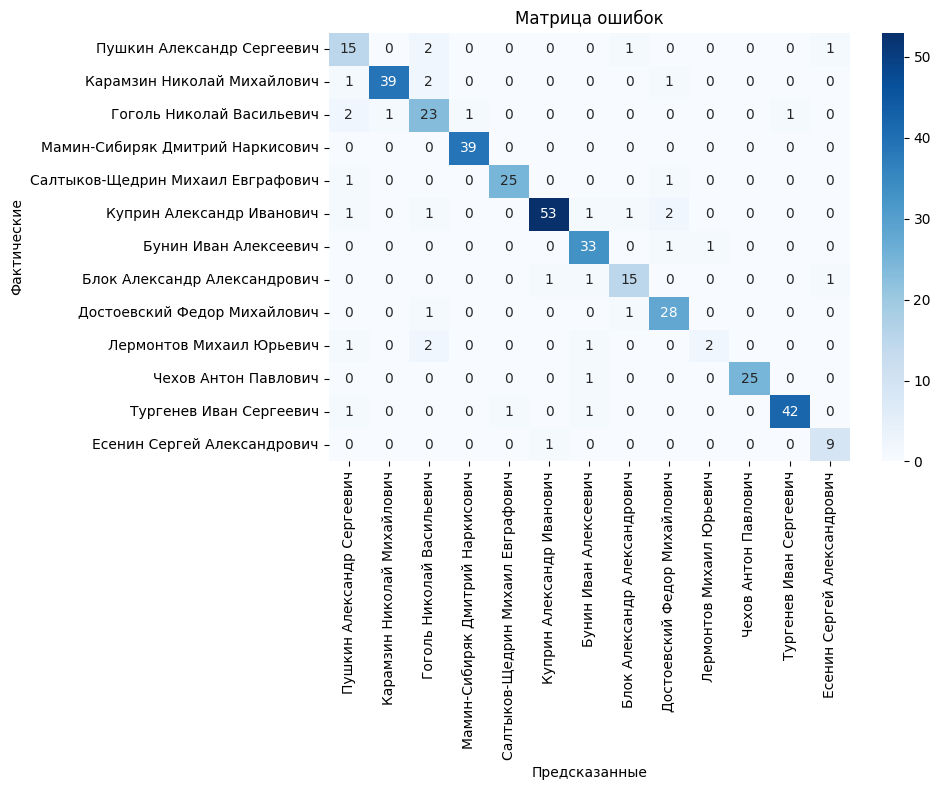

In [17]:
final_loss, final_f1, final_preds, final_labels = evaluate(model, test_dataloader)
print(f"Final F1: {final_f1}")

print(classification_report(final_labels, final_preds, target_names=list(id_to_author.values())))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(final_labels, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(id_to_author.values()), yticklabels=list(id_to_author.values()))
plt.xlabel('Предсказанные')
plt.ylabel('Фактические')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

In [18]:
# model.save_pretrained(model_file_name)
# tokenizer.save_pretrained(model_file_name)
# print(f"Модель сохранена в {model_file_name}")

In [19]:
def predict_author(text):
    encoding = tokenizer(
        text,
        truncation=True,
        max_length=512,
        padding='max_length',
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    predicted_class_id = torch.argmax(logits, dim=1).item()

    predicted_author = id_to_author[predicted_class_id]

    probabilities = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()[0]

    return predicted_author, probabilities

Тут приведен сложный пример Пушкина, автор которого, как правило, не определяется корректно в результате наших экспериментов.

In [20]:
# Да, это Пушкин
example_text = """У Гальяни иль Кольони
Закажи себе в Твери
С пармазаном макарони,
Да яишницу свари."""

predicted_author, probabilities = predict_author(example_text)
print(f"Предсказанный автор: {predicted_author}")
print("Вероятности для каждого автора:")
for i, prob in enumerate(probabilities):
    print(f"{id_to_author[i]}: {prob:.4f}")

Предсказанный автор: Есенин Сергей Александрович
Вероятности для каждого автора:
Пушкин Александр Сергеевич: 0.0120
Карамзин Николай Михайлович: 0.0173
Гоголь Николай Васильевич: 0.0061
Мамин-Сибиряк Дмитрий Наркисович: 0.0147
Салтыков-Щедрин Михаил Евграфович: 0.0111
Куприн Александр Иванович: 0.0101
Бунин Иван Алексеевич: 0.0142
Блок Александр Александрович: 0.0274
Достоевский Федор Михайлович: 0.0041
Лермонтов Михаил Юрьевич: 0.0184
Чехов Антон Павлович: 0.0102
Тургенев Иван Сергеевич: 0.0071
Есенин Сергей Александрович: 0.8473


## Выводы

### Архитектура:
- В качестве основы используется предобученная русскоязычная модель `DeepPavlov/rubert-base-cased`
- Применяется полный fine-tuning
- Последний слой адаптирован для классификации по нескольким авторам

### Особенности обучения:
- Использован оптимизатор AdamW с регуляризацией weight_decay=0.05 для борьбы с переобучением
- Применена стратегия изменения скорости обучения OneCycleLR для более эффективной сходимости
- Реализована ранняя остановка обучения для предотвращения переобучения
- Используются батчи размером 16, что обеспечивает стабильность обучения
- Важной деталью является удаление имен авторов и их вариаций для исключения "утечки" информации


### Результаты:
- График функции потерь демонстрирует стабильное обучение
- Матрица ошибок визуализирует, какие авторы чаще всего путаются между собой
- Метрика F1 показывает высокое качество классификации, сопоставимое с лучшими результатами, полученными ранее.